#### testing MSE-based instability proxy and its relationship with MCS
- check if instability (thetae_850 - thetae_500) can protrait where MCS are located 

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from numba import jit, vectorize, float64
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

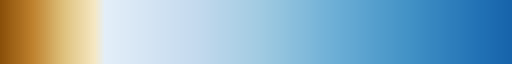

In [3]:
colors1 = plt.cm.BrBG(np.linspace(0.1, 0.4, 10))
colors2 = plt.cm.Blues(np.linspace(0.1, 0.8, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [4]:
@jit(nopython=False)
def es_calc_bolton(temp):
    # in hPa

    tmelt  = 273.15
    tempc = temp - tmelt
    es = 6.112*np.exp(17.67*tempc/(243.5+tempc))

    return es

In [5]:
@jit(nopython=False)
def es_calc(temp):
    """
    temp [x,p]
    """
    tmelt  = 273.15

    c0=0.6105851e+03
    c1=0.4440316e+02
    c2=0.1430341e+01
    c3=0.2641412e-01
    c4=0.2995057e-03
    c5=0.2031998e-05
    c6=0.6936113e-08
    c7=0.2564861e-11
    c8=-.3704404e-13

    tempc = temp - tmelt
    tempcorig = tempc

    #if tempc < -80:
    es_ltn80c = es_calc_bolton(temp)
    es_ltn80c = np.where(tempc < -80, es_ltn80c, 0)
    
    #else:
    es = c0+tempc*(c1+tempc*(c2+tempc*(c3+tempc*(c4+tempc*(c5+tempc*(c6+tempc*(c7+tempc*c8)))))))
    es_gtn80c = es/100
    es_gtn80c = np.where(tempc >= -80, es_gtn80c, 0)

    # complete es
    es = es_ltn80c + es_gtn80c

    return es

In [6]:
@jit(nopython=False)
def qs_calc(temp, p_level):

    tmelt  = 273.15
    RV=461.5
    RD=287.04

    EPS=RD/RV

    press = p_level * 100. # in Pa
    tempc = temp - tmelt

    es=es_calc(temp) # [x,y,p]
    es=es * 100. #hPa
    
    qs = (EPS * es) / (press + ((EPS-1.)*es))

    return qs

#### load data and plot figure into fig directory
- take 2018 as example

In [7]:
%%time
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/2018')

for month_sel in np.arange(9,13):

    print('processing month : {}'.format(month_sel))
    ds_z = xr.open_dataset(era5_dir / 'era-5.z.2018.{}.nc'.format(str(month_sel).zfill(2))).rename({'valid_time':'time'})
    ds_t = xr.open_dataset(era5_dir / 'era-5.T.2018.{}.nc'.format(str(month_sel).zfill(2)))
    ds_q = xr.open_dataset(era5_dir / 'era-5.q.2018.{}.nc'.format(str(month_sel).zfill(2)))
    ds_t2m = xr.open_dataset(era5_dir / 'era-5.2t.2018.{}.nc'.format(str(month_sel).zfill(2))) # temperature at 2m
    ds_sp = xr.open_dataset(era5_dir / 'era-5.sp.2018.{}.nc'.format(str(month_sel).zfill(2))) # surface pressure at 2m
    ds_d2m = xr.open_dataset(era5_dir / 'era-5.2d.2018.{}.nc'.format(str(month_sel).zfill(2))) # dew point temperature at 2m

    mask_dir = Path('/neelin2020/RGMA_feature_mask/data_product/2018/MERGED_FP')
    ds_feat = xr.open_dataset(mask_dir / 'GPM_feature_merged_{}_v4_mcsnew.nc'.format(str(month_sel).zfill(2)))
    mcs_mask = ds_feat.mcs_tag
    ar_mask = ds_feat.ar_tag
    ft_mask = ds_feat.front_c_tag
    prec = ds_feat.precipitationCal

    # calculate q2m from d2m
    d2m = ds_d2m.VAR_2D * units.K
    sp = ds_sp.SP * units.Pa
    ds_q2m = specific_humidity_from_dewpoint(sp, d2m) # now metpy.16 supports xarray!

    out_dir = Path('/scratch/wmtsai/temp_mcs/fig_MCS_MSEinstability/MSE850_500/{}'.format(str(month_sel).zfill(2)))
    os.system('mkdir -p {}'.format(out_dir))

    for n,time_sel in enumerate(ds_feat.time.values):
        #print('Time = {}'.format(time_sel))
        cp = 1004.
        Lv = 2.5e6

        z = ds_z.z.sel(time=time_sel) # geopotential 
        T = ds_t.t.sel(time=time_sel)
        q = ds_q.q.sel(time=time_sel)
        T2m = ds_t2m.VAR_2T.sel(time=time_sel)
        q2m = ds_q2m.sel(time=time_sel)

        mcs_map = mcs_mask.sel(time=time_sel)
        ar_map = ar_mask.sel(time=time_sel)
        ft_map = ft_mask.sel(time=time_sel)
        ft_nhmap = ft_map.where(ft_map.latitude > 35, 0)
        ft_shmap = ft_map.where(ft_map.latitude < -35, 0)
        ft_glbmap = ft_nhmap + ft_shmap

        # calculate qsat at 500 hPa
        p_level = 500 #ds_t.level.values # hPa
        qsat_500 = np.zeros((T.shape[1],T.shape[2]))
        T_500 = T.sel(level=500).values
        qsat_500 = qs_calc(T_500, p_level)
        # MSE at surface 2m
        mse_sfc = (cp*T2m + Lv*q2m + 2*9.81)/1000 # KJ/kg
        # MSE at 850hPa
        mse_850 = ( cp*T.sel(level=850) + Lv*q.sel(level=850) + z.sel(pressure_level=850) )/1000 # KJ/kg
        # MSE_sat at 500hPa
        mse_sat_500 = ( cp*T.sel(level=500) + Lv*qsat_500 + z.sel(pressure_level=500) )/1000 # KJ/kg

        # plot figure
        fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
        ax.coastlines(resolution='50m', color='k',linewidth=0.5)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)

        dmse_masked = mse_850 - mse_sat_500
        dmse_masked = dmse_masked.where(dmse_masked >= -5)

        cp = ax.pcolormesh(mse_sfc.longitude, mse_sfc.latitude, dmse_masked, vmin=-5,vmax=10
                        , cmap=mixedmap, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.02, extend='max')
        cp.cmap.set_under('w')
        cbar.ax.tick_params(labelsize=9) 
        cbar.set_label('MSE$_{850}$ - MSE$_{500,sat}$ (KJ/kg)',fontsize=9)
        #ax.contour(mse_850.longitude, mse_850.latitude, mse_850 - mse_sat_500, levels=[0], colors=['r'], linewidths=0.5
        #           , transform=ccrs.PlateCarree())

        # add MCS features on top of the MSE map
        ax.contourf(mcs_map.longitude, mcs_map.latitude, mcs_map, levels=[0.9,1.1], zorder=2, colors=['m'], alpha=0.7
                , transform=ccrs.PlateCarree())
        # add AR features
        ax.contour(ar_map.longitude, ar_map.latitude, ar_map, levels=[0.9,1.1], colors=['g'], zorder=2, alpha=0.6, linewidths=1
                , transform=ccrs.PlateCarree())
        # add FT features
        ax.contour(ft_mask.longitude, ft_mask.latitude, ft_glbmap, levels=[0.9,1.1], colors=['blue'], zorder=2, alpha=0.7, linewidths=1
                , transform=ccrs.PlateCarree())

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=1, color='gray', alpha=0.4, linestyle=':')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size':9}
        gl.ylabel_style = {'size':9}
        ax.set_ylim([-60,60])

        # get time information for the title
        year = str(time_sel)[:4]
        month = str(time_sel)[5:7]
        day = str(time_sel)[8:10]
        hour = str(time_sel)[11:13]
        ax.set_title('MSE-based instability (MSE$_{850}$-MSE$_{sat,500}$) ' + 'MCS (magenta) & AR (green) & FT (blue) features \n {}.{}.{}.{}'.format(year,month,day,hour),fontsize=8.5)
        fig.savefig(out_dir / 'MCS_MSEinstability_{}.png'.format(str(n).zfill(3)),
                  dpi=600, bbox_inches='tight', transparent=False)
        plt.close()

processing month : 9
processing month : 10
processing month : 11
processing month : 12
CPU times: user 38min 14s, sys: 7min 58s, total: 46min 13s
Wall time: 47min 33s


In [ ]:
# plot figure
fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(resolution='50m', color='k',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)

dmse_masked = mse_sfc - mse_sat_500
dmse_masked = dmse_masked.where(dmse_masked >= -5)

cp = ax.pcolormesh(mse_sfc.longitude, mse_sfc.latitude, dmse_masked, vmin=-5,vmax=10
        , cmap=mixedmap, transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.02, extend='max')
cp.cmap.set_under('w')
cbar.ax.tick_params(labelsize=9) 
cbar.set_label('MSE$_{sfc}$ - MSE$_{500,sat}$ (KJ/kg)',fontsize=9)

# add MCS features on top of the MSE map
ax.contourf(mcs_map.longitude, mcs_map.latitude, mcs_map, levels=[0.9,1.1], zorder=2, colors=['m'], alpha=0.7
        , transform=ccrs.PlateCarree())
# add AR features
ax.contour(ar_map.longitude, ar_map.latitude, ar_map, levels=[0.9,1.1], colors=['g'], zorder=2, alpha=0.6, linewidths=1
        , transform=ccrs.PlateCarree())
# add FT features
ax.contour(ft_glbmap.longitude, ft_glbmap.latitude, ft_glbmap, levels=[0.9,1.1], zorder=2, alpha=0.7, linewidths=1
       , transform=ccrs.PlateCarree())

In [ ]:
%%time
# calculate MSE at 850hPa and MSE_sat 500hPa at the first timestep (2018, 01, 01, 00Z)

out_dir = Path('/scratch/wmtsai/temp_mcs/fig_MCS_MSEinstability/MSEsfc_500/{}'.format(str(month).zfill(2)))
os.system('mkdir -p {}'.format(out_dir))

for n,time_sel in enumerate(ds_feat.time.values[:1]):
    print('Time = {}'.format(time_sel))
    cp = 1004.
    Lv = 2.5e6

    z = ds_z.z.sel(time=time_sel) # geopotential 
    T = ds_t.t.sel(time=time_sel)
    q = ds_q.q.sel(time=time_sel)
    T2m = ds_t2m.VAR_2T.sel(time=time_sel)
    q2m = ds_q2m.sel(time=time_sel)

    mcs_map = mcs_mask.sel(time=time_sel)
    ar_map = ar_mask.sel(time=time_sel)
    ft_map = ft_mask.sel(time=time_sel)
    ft_nhmap = ft_map.where(ft_map.latitude > 35, 0)
    ft_shmap = ft_map.where(ft_map.latitude < -35, 0)
    ft_glbmap = ft_nhmap + ft_shmap

    # calculate qsat at 500 hPa
    p_level = 500 #ds_t.level.values # hPa
    qsat_500 = np.zeros((T.shape[1],T.shape[2]))
    T_500 = T.sel(level=500).values
    qsat_500 = qs_calc(T_500, p_level)
    # MSE at surface 2m
    mse_sfc = (cp*T2m + Lv*q2m + 2*9.81)/1000 # KJ/kg
    # MSE at 850hPa
    mse_850 = ( cp*T.sel(level=850) + Lv*q.sel(level=850) + z.sel(pressure_level=850) )/1000 # KJ/kg
    # MSE_sat at 500hPa
    mse_sat_500 = ( cp*T.sel(level=500) + Lv*qsat_500 + z.sel(pressure_level=500) )/1000 # KJ/kg

    # plot figure
    fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='50m', color='k',linewidth=0.5)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)

    dmse_masked = mse_sfc - mse_sat_500
    dmse_masked = dmse_masked.where(dmse_masked >= -5)

    cp = ax.pcolormesh(mse_sfc.longitude, mse_sfc.latitude, dmse_masked, vmin=-5,vmax=10
                    , cmap=mixedmap, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.02, extend='max')
    cp.cmap.set_under('w')
    cbar.ax.tick_params(labelsize=9) 
    cbar.set_label('MSE$_{sfc}$ - MSE$_{500,sat}$ (KJ/kg)',fontsize=9)
    #ax.contour(mse_850.longitude, mse_850.latitude, mse_850 - mse_sat_500, levels=[0], colors=['r'], linewidths=0.5
    #           , transform=ccrs.PlateCarree())

    # add MCS features on top of the MSE map
    ax.contourf(mcs_map.longitude, mcs_map.latitude, mcs_map, levels=[0.9,1.1], zorder=2, colors=['m'], alpha=0.7
            , transform=ccrs.PlateCarree())
    # add AR features
    ax.contour(ar_map.longitude, ar_map.latitude, ar_map, levels=[0.9,1.1], colors=['g'], zorder=2, alpha=0.6, linewidths=1
            , transform=ccrs.PlateCarree())
    # add FT features
    ax.contour(ft_mask.longitude, ft_mask.latitude, ft_glbmap, levels=[0,1,2], colors=['blue'], zorder=2, alpha=0.7, linewidths=1
             , transform=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':9}
    gl.ylabel_style = {'size':9}
    ax.set_ylim([-60,60])

    # get time information for the title
    year = str(time_sel)[:4]
    month = str(time_sel)[5:7]
    day = str(time_sel)[8:10]
    hour = str(time_sel)[11:13]
    ax.set_title('MSE-based instability (MSE$_{sfc}$-MSE$_{sat,500}$) ' + 'MCS (magenta) & AR (green) & FT (blue) features \n {}.{}.{}.{}'.format(year,month,day,hour),fontsize=8.5)
    #fig.savefig(out_dir / 'MCS_MSEinstability_{}.png'.format(str(n).zfill(3)),
    #          dpi=600, bbox_inches='tight', transparent=False)
    #plt.close()

In [ ]:
%%time
# frequency distribution of MSE instability (MSE_sfc - MSE_sat_500)
bins_mse = np.linspace(-40,20,61)
samples_notmcs = np.zeros(len(bins_mse)-1)
samples_mcs = np.copy(samples_notmcs)

for n,time_sel in enumerate(ds_feat.time.values):
    #print('Time = {}'.format(time_sel))
    cp = 1004.
    Lv = 2.5e6

    z = ds_z.z.sel(time=time_sel) # geopotential 
    T = ds_t.t.sel(time=time_sel)
    q = ds_q.q.sel(time=time_sel)
    T2m = ds_t2m.VAR_2T.sel(time=time_sel)
    q2m = ds_q2m.sel(time=time_sel)

    mcs_map = mcs_mask.sel(time=time_sel)
    ar_map = ar_mask.sel(time=time_sel)

    # calculate qsat at 500 hPa
    p_level = 500 #ds_t.level.values # hPa
    qsat_500 = np.zeros((T.shape[1],T.shape[2]))
    T_500 = T.sel(level=500).values
    qsat_500 = qs_calc(T_500, p_level)
    # MSE at surface 2m
    mse_sfc = (cp*T2m + Lv*q2m + 2*9.81)/1000 # KJ/kg
    mse_sat_500 = ( cp*T.sel(level=500) + Lv*qsat_500 + z.sel(pressure_level=500) )/1000 # KJ/kg

    # not mcs grids
    dmse = mse_sfc - mse_sat_500
    dmse_notmcs = dmse.where(mcs_mask == 0)
    (samples, bins_mse) = np.histogram(dmse_notmcs, bins=bins_mse)
    samples_notmcs += samples
    # mcs grids
    dmse_mcs = dmse.where(mcs_mask > 0)
    (samples, bins_mse) = np.histogram(dmse_mcs, bins_mse)
    samples_mcs += samples
    


In [ ]:
plt.plot(bins_mse[:-1], samples_notmcs/np.sum(samples_notmcs))
plt.plot(bins_mse[:-1], samples_mcs/np.sum(samples_mcs))
#plt.plot(bins_mse[:-1], samples_mcs/np.sum(samples_mcs + samples_notmcs), '--')

#### 2. PDFs of MSE-based instability: all vs MCS
- take the entire January as an example data

In [4]:
mask_dir = Path('/neelin2020/RGMA_feature_mask/data_product/2018/MERGED_FP')
ds_feat = xr.open_dataset(mask_dir / 'GPM_feature_merged_01_v4_mcsnew.nc')
mcs_mask = ds_feat.mcs_tag
ar_mask = ds_feat.ar_tag
ft_mask = ds_feat.front_c_tag
prec = ds_feat.precipitationCal

In [23]:
mse_dir = Path('/neelin2020/ERA-5_mse/2018')
ds_mse = xr.open_dataset(mse_dir / 'ERA-5.mse.2018.01.nc').sel(time=ds_feat.time, latitude=slice(60,-60))
ds_mse['dmse'] = ds_mse.mse_850 - ds_mse.mse_sat_500
ds_tb = xr.open_dataset(mask_dir / '../MERGE-IR/Tb_MERGE_IR_2018_01_hrly.compress_new.nc').sel(time=ds_feat.time, method='nearest').sel(lat=slice(-60,60))
ds_tb = ds_tb.rename({'lat':'latitude','lon':'longitude'})
ds_tb['time'] = ds_feat.time.values

In [24]:
# match hourly MSE dataset and 6-hourly feature masks in time
ds_merged_6hrly = xr.merge([ds_mse, ds_feat, ds_tb])
ds_merged_6hrly

<xarray.Dataset> Size: 3GB
Dimensions:           (latitude: 481, longitude: 1440, time: 124)
Coordinates:
  * latitude          (latitude) float64 4kB -60.0 -59.75 -59.5 ... 59.75 60.0
  * longitude         (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * time              (time) datetime64[ns] 992B 2018-01-01 ... 2018-01-31T18...
    number            int64 8B ...
    expver            (time) <U4 2kB ...
Data variables:
    mse_sfc           (time, latitude, longitude) float32 344MB ...
    mse_850           (time, latitude, longitude) float32 344MB ...
    mse_sat_500       (time, latitude, longitude) float32 344MB ...
    dmse              (time, latitude, longitude) float32 344MB -18.76 ... -2...
    precipitationCal  (time, latitude, longitude) float32 344MB ...
    ar_tag            (time, latitude, longitude) int8 86MB ...
    front_c_tag       (time, latitude, longitude) int8 86MB ...
    front_w_tag       (time, latitude, longitude) int8 86MB ...
    front_s_tag       (time, latitude, longitude) int8 86MB ...
    lps_tag           (time, latitude, longitude) int8 86MB ...
    mcs_tag           (time, latitude, longitude) int8 86MB ...
    tb                (time, latitude, longitude) float32 344MB ...
Attributes:
    unit:          KJ/kg
    created date:  2024-10-21

#### PDFs of the rainy grids: All rainy grids vs. MCS rainy grids

In [11]:
# ds_merged_rain = ds_merged_6hrly.where(ds_merged_6hrly.precipitationCal > 0.5)
# ds_mcsasso_rain = ds_merged_rain.where(ds_merged_rain.mcs_tag > 0)

# dmse_all_tropics = ds_merged_rain.dmse_850_500.sel(latitude=slice(-30,30))
# dmse_mcs_tropics = ds_mcsasso_rain.dmse_850_500.sel(latitude=slice(-30,30))
# # check PDF 
# dmse_bins = np.arange(-40,15,0.5)
# (samples_all_trop, bins_edge) = np.histogram(dmse_all_tropics, bins=dmse_bins)
# (samples_mcs_trop, bins_edge) = np.histogram(dmse_mcs_tropics, bins=dmse_bins)

# dmse_all_extra = ds_merged_rain.dmse_850_500.sel(latitude=slice(30,60))
# dmse_mcs_extra = ds_mcsasso_rain.dmse_850_500.sel(latitude=slice(30,60))
# # check PDF 
# dmse_bins = np.arange(-40,15,0.5)
# (samples_all_extra, bins_edge) = np.histogram(dmse_all_extra, bins=dmse_bins)
# (samples_mcs_extra, bins_edge) = np.histogram(dmse_mcs_extra, bins=dmse_bins)

In [12]:
# fig, ax = plt.subplots(figsize=(4,4))

# ax.plot(bins_edge[:-1], samples_all_trop/np.sum(samples_all_trop), color='k')
# ax.plot(bins_edge[:-1], samples_mcs_trop/np.sum(samples_mcs_trop), color='r')
# # accumulative 
# ax2 = ax.twinx()
# ax2.plot(bins_edge[:-1], np.cumsum(samples_mcs_trop)/np.sum(samples_mcs_trop), '--r')
# ax.tick_params(labelsize=9)
# ax.set_ylabel('PDF')
# ax.set_xlabel('MSE$_{850}$ - MSE$_{sat,500}$ (KJ/kg)')
# ax2.set_ylabel('Cumulative PDF of the red')
# ax.legend(['All grids','MCS-associated'],loc=2)
# ax.set_ylim(bottom=0)
# ax2.set_ylim([0,1.05])
# ax.grid(ls=':',lw=0.5)
# ax.set_xlim([-40,15])
# ax.set_title('PDF of instability (30S-30N)',fontsize=10)
# plt.show()

In [13]:
# plt.plot(bins_edge[:-1], 100*samples_mcs_trop/samples_all_trop)
# plt.xlim([-40,15])

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(bins_edge[:-1], samples_all_extra/np.sum(samples_all_extra), color='k')
ax.plot(bins_edge[:-1], samples_mcs_extra/np.sum(samples_mcs_extra), color='r')
# accumulative 
ax2 = ax.twinx()
ax2.plot(bins_edge[:-1], np.cumsum(samples_mcs_extra)/np.sum(samples_mcs_extra), '--r')
ax.tick_params(labelsize=9)
ax.set_ylabel('PDF')
ax.set_xlabel('MSE$_{850}$ - MSE$_{sat,500}$ (KJ/kg)')
ax2.set_ylabel('Cumulative PDF of the red')
ax.legend(['All grids','MCS-associated'],loc=2)
ax.set_ylim([0,0.06])
ax.set_ylim(bottom=0)
ax.grid(ls=':',lw=0.5)
ax.set_xlim([-40,15])
ax.set_title('PDF of instability (30N-60N)',fontsize=10)
plt.show()

In [ ]:
plt.plot(bins_edge[:-1], 100*samples_mcs_extra/samples_all_extra)
plt.xlim([-40,15])

#### 3. Logistic regression model and ROC cure anaylysis
- testing theta_850 - theta_e_sat,500
- which thershold can best identify areas of MCSs

In [ ]:
%%time
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# target: predicting MCS over rainy areas 
# predictors: MSE components at 850 and 500, precipitation
mcs_map = ds_merged_6hrly.isel(time=slice(0,10)).mcs_tag
dmse_map = ds_merged_6hrly.isel(time=slice(0,10)).dmse
prec_map = ds_merged_6hrly.isel(time=slice(0,10)).precipitation
tb_map = ds_merged_6hrly.isel(time=slice(0,10)).tb
dmse_n5k = dmse_map.where(dmse_map > -100, 0)
#dmse_n5k = dmse_n5k.where(dmse_n5k == 0, 1)

# Sample data using the first 100 time records for training
data = {
    'dmse': dmse_n5k.values.ravel(),
    'mcs_tag': mcs_map.values.ravel()  # Ensure both classes are represented
}

df = pd.DataFrame(data)

# Defining the independent variables and the target variable
# predictors using mse estimates and precip
#x = df[['dmse_850_500', 'mse_850', 'mse_sat_500', 'precip']]
x = df[['dmse']]

# predicted outcome: MCS or not
y = df['mcs_tag']

# Splitting the data into training and testing sets with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Train a logistic regression model
model = LogisticRegression() 
model.fit(x_train, y_train)
# Predict probabilities on the test set
y_pred_proba = model.predict_proba(x_test)[:, 1] 

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred_proba)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

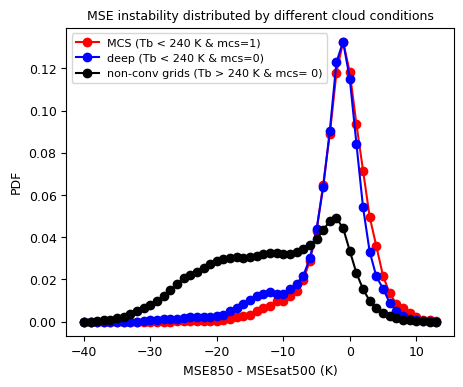

In [40]:
lat_bound = 30

mcs_map = ds_merged_6hrly.isel(time=slice(0,10)).mcs_tag.sel(latitude=slice(-lat_bound, lat_bound))
dmse_map = ds_merged_6hrly.isel(time=slice(0,10)).dmse.sel(latitude=slice(-lat_bound, lat_bound))
prec_map = ds_merged_6hrly.isel(time=slice(0,10)).precipitationCal.sel(latitude=slice(-lat_bound, lat_bound))
tb_map = ds_merged_6hrly.isel(time=slice(0,10)).tb.sel(latitude=slice(-lat_bound, lat_bound))

dmse_mcs = dmse_map.where((mcs_map > 0))
dmse_deep = dmse_map.where((mcs_map == 0) & (tb_map <= 240))
dmse_noconv = dmse_map.where((mcs_map == 0) & (tb_map > 240))

tmp = dmse_mcs.values.ravel()
tmp = tmp[~np.isnan(tmp)]
tmp2 = dmse_deep.values.ravel()
tmp2 = tmp2[~np.isnan(tmp2)]
tmp3 = dmse_noconv.values.ravel()
tmp3 = tmp3[~np.isnan(tmp3)]
samples, bins_edge = np.histogram(tmp, bins=np.arange(-40,15))
samples2, bins_edge = np.histogram(tmp2, bins=np.arange(-40,15))
samples3, bins_edge = np.histogram(tmp3, bins=np.arange(-40,15))

fig = plt.figure(figsize=(5,4))
plt.plot(bins_edge[:-1], samples/samples.sum(), '-or', label='MCS (Tb < 240 K & mcs=1)')
plt.plot(bins_edge[:-1], samples2/samples2.sum(), '-ob', label='deep (Tb < 240 K & mcs=0)')
plt.plot(bins_edge[:-1], samples3/samples3.sum(), '-ok', label='non-conv grids (Tb > 240 K & mcs= 0)')

plt.ylabel('PDF',fontsize=9)
plt.xlabel('MSE850 - MSEsat500 (K)',fontsize=9)
plt.tick_params(labelsize=9)
plt.legend(fontsize=8)
plt.title('MSE instability distributed by different cloud conditions',fontsize=9)
plt.show()

In [ ]:
# Making predictions with the trained regression model above for another dataset

time_sel = 101

# create lat,lon meshgrid for records
lon_mesh, lat_mesh = np.meshgrid(ds_merged_rain.longitude, ds_merged_rain.latitude)

data = {
    'dmse_850_500': ds_merged_rain.isel(time=time_sel).dmse.values.ravel(),
    'mse_850': ds_merged_rain.isel(time=time_sel).mse_850.values.ravel(),
    'mse_sat_500': ds_merged_rain.isel(time=time_sel).mse_sat_500.values.ravel(),
    'precip': ds_merged_rain.isel(time=time_sel).precipitationCal.values.ravel(),
    #'tb': ds_merged_rain.isel(time=time_sel).tb.values.ravel(),
    'lat': lat_mesh.ravel(),
    'lon': lon_mesh.ravel(),
    'mcs_tag': ds_merged_rain.isel(time=time_sel).mcs_tag.values.ravel()  # Ensure both classes are represented
        }
df_test = pd.DataFrame(data)
#df_test = df_test.fillna(0)
X_test = df_test[['dmse_850_500','precip']]
y_test = df_test['mcs_tag']

# predict mcs_tag
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

In [ ]:
# get predicted map and true map of mcs_tag
mcs_tag_pred = np.reshape(y_pred,(481,1440))    
mcs_tag_true = ds_merged_rain.isel(time=time_sel).mcs_tag

mse_850 = ds_merged_rain.isel(time=time_sel).mse_850
mse_sat_500 = ds_merged_rain.isel(time=time_sel).mse_sat_500

fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(resolution='50m', color='k',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)

cp = ax.pcolormesh(mse_850.longitude, mse_850.latitude, mse_850 - mse_sat_500, vmin=-20,vmax=10
                   , cmap='BrBG', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('MSE$_{850}$ - MSE$_{500,sat}$ (KJ/kg)')

#add predicted 
ax.contour(mse_850.longitude, mse_850.latitude, mcs_tag_pred, levels=[0,1], colors=['r'], linewidths=1, zorder=2
         , transform=ccrs.PlateCarree())
#add true
ax.contour(mse_850.longitude, mse_850.latitude, mcs_tag_true, levels=[0,1], colors=['b'], linewidths=1, zorder=2
         , transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

ax.set_ylim([-60,60])
#ax.set_xlim([0,180])

ax.set_title('Prediction of trained regression model [Time=slice(0,100)]. Time=101 \n MCS$_{predicted}$ (red), MCS$_{true}$ (blue)',fontsize=10)
plt.show()

In [51]:
def create_df_input(ds_merged_rain, time_sel):
    
    # Making predictions with the trained regression model above for another dataset
    data = {
        'dmse_850_500': ds_merged_rain.isel(time=time_sel).dmse.values.ravel(),
        'mse_850': ds_merged_rain.isel(time=time_sel).mse_850.values.ravel(),
        'mse_sat_500': ds_merged_rain.isel(time=time_sel).mse_sat_500.values.ravel(),
        'precip': ds_merged_rain.isel(time=time_sel).precipitationCal.values.ravel(),
        'mcs_tag': ds_merged_rain.isel(time=time_sel).mcs_tag.values.ravel()  # Ensure both classes are represented
           }
    df_test = pd.DataFrame(data)
    df_test = df_test.fillna(0)
    X_test = df_test[['dmse_850_500', 'mse_850', 'mse_sat_500','precip']]
    y_test = df_test['mcs_tag']
    
    # predict mcs_tag
    y_pred = model.predict(X_test)
    
    y_true = df_test['mcs_tag'].values
    total_mcsgrid = np.sum(y_true)
    mcsgrid_predicted = 0
    for i in range(len(y_true)):
        if (y_true[i] == 1) and (y_true[i] == y_pred[i]):
            mcsgrid_predicted +=1
    accuracy_mcs = mcsgrid_predicted/total_mcsgrid
            
    # Evaluating the model
    accuracy_all = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy_mcs, accuracy_all, conf_matrix

In [53]:
### apply this trained model to other months and years to evaluate accuracy 

year = 2018
accuracy_mcs_list = []
for month in np.arange(2,3):
    
    mask_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))
    ds_feat = xr.open_dataset(mask_dir / 'GPM_feature_merged_{}_v4_mcsnew.nc'.format(str(month).zfill(2)))
    mcs_mask = ds_feat.mcs_tag
    prec = ds_feat.precipitationCal
    
    mse_dir = Path('/neelin2020/ERA-5_mse/{}'.format(year))
    ds_mse = xr.open_dataset(mse_dir / 'ERA-5.mse.{}.{}.nc'.format(year,str(month).zfill(2))).sel(time=ds_feat.time, latitude=slice(60,-60))
    ds_mse['dmse'] = ds_mse.mse_850 - ds_mse.mse_sat_500
    # match hourly MSE dataset and 6-hourly feature masks in time
    ds_merged_6hrly = xr.merge([ds_mse, ds_feat])
    
    for t in range(len(ds_merged_6hrly.time)):
        (accuracy_mcs, accuracy_all, conf_matrix) = create_df_input(ds_merged_6hrly, time_sel=t)
        accuracy_mcs_list.append(accuracy_mcs)                                